In [1]:
import pickle
import random
from collections.abc import Iterable

import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
from nltk import conlltags2tree, tree2conlltags
from nltk.chunk import ChunkParserI
from nltk.tag import ClassifierBasedTagger

InteractiveShell.ast_node_interactivity = 'none'
plt.style.use(['dark_background'])


In [2]:
# import parsed sentences
with open('results/parsed_sentences_shallow.pickle', 'rb') as file:
    parsed_sentences = pickle.load(file)

# import lemmata
with open('results/lemmata.pickle', 'rb') as file:
    lemmata = pickle.load(file)


In [3]:
# used chunked data to create an IOB-tagged corpus
# iob_tagged = tree2conlltags(cs)
iob_tagged_sentences = []  # store results

for sent in parsed_sentences[:-1]:
    iob = tree2conlltags(sent)
    iob_tagged_sentences.append([((w, t), iob) for w, t, iob in iob])

print(f'IOB-tagging completed. {len(iob_tagged_sentences)} sentences processed.')


IOB-tagging completed. 203 sentences processed.


In [4]:
iob_lines = []
for sentence in iob_tagged_sentences:
    iob_triplets = [(w, t, c) for ((w, t), c) in sentence]
    for iob in iob_triplets:
        word = iob[0]
        pos = iob[1].split('-')[0]
        iob_tag = iob[2]
        iob_lines.append(f'{word}, {pos} {iob_tag}')
    iob_lines.append('')

# save results to a local file
with open('results/chunks_iob.txt', 'w') as file:
    for line in iob_lines:
        file.write(f'{line}\n')


In [5]:
def features(tokens, index, history):
    """Extract features from tokens in IOB tagged trees.

    Args:
        tokens: a POS-tagged sentence [(w1, t1), ...]
        index: the index of the token we want to extract features for
        history: the previous predicted IOB tags

    """

    def clean_pos(pos):
        include = ['Gender', 'Number', 'VerbForm', 'Case', 'Tense', 'Aspect', 'Voice', 'Mood', 'Person']
        if '-' in pos:
            pos_list = pos.split('-')
            upos = pos_list[0]
            if '|' in pos_list[1]:
                xpos = []
                for tag in pos_list[1].split('|'):
                    for t in include:
                        if t in tag:
                            xpos.append(tag)
                xpos = '|'.join(xpos)
            else:
                xpos = pos_list[1]
            return (upos, xpos)

        return (pos, pos)

    # Pad the sequence with placeholders
    tokens = [
        ('[START2]', '[START2]'),
        ('[START1]', '[START1]'),
        *list(tokens),
        ('[END1]', '[END1]'),
        ('[END2]', '[END2]'),
    ]
    history = ['[START2]', '[START1]', *list(history)]

    # shift the index with 2, to accommodate the padding
    index += 2

    word, pos = tokens[index]
    upos, xpos = clean_pos(pos)
    lemma = lemmata.get(word, '')

    prev_word, prev_pos = tokens[index - 1]
    prev_upos, prev_xpos = clean_pos(prev_pos)
    prev_lemma = lemmata.get(prev_word, '')

    prev_prev_word, prev_prev_pos = tokens[index - 2]
    prev_prev_upos, prev_prev_xpos = clean_pos(prev_prev_pos)
    prev_prev_lemma = lemmata.get(prev_prev_word, '')

    next_word, next_pos = tokens[index + 1]
    next_upos, next_xpos = clean_pos(next_pos)
    next_lemma = lemmata.get(next_word, '')

    next_next_word, next_next_pos = tokens[index + 2]
    next_next_upos, next_next_xpos = clean_pos(next_next_pos)
    next_next_lemma = lemmata.get(next_next_word, '')

    return {
        'word': word,
        'lemma': lemma or None,
        'upos': upos,
        'xpos': xpos or None,
        'word-length': len(word),
        'next-word': next_word,
        'next-lemma': next_lemma or None,
        'next-upos': next_upos,
        'next-xpos': next_xpos or None,
        'next-word-length': len(next_word),
        'next-next-word': next_next_word,
        'next-next-lemma': next_next_lemma or None,
        'next-next-upos': next_next_upos,
        'next-next-xpos': next_next_xpos or None,
        'next-next-word-length': len(next_next_word),
        'prev-word': prev_word,
        'prev-lemma': prev_lemma or None,
        'prev-upos': prev_upos,
        'prev-xpos': prev_xpos or None,
        'prev-word-length': len(prev_word),
        'prev-prev-word': prev_prev_word,
        'prev-prev-lemma': prev_prev_lemma or None,
        'prev-prev-upos': prev_prev_upos,
        'prev-prev-xpos': prev_prev_xpos or None,
        'prev-prev-word-length': len(prev_prev_word),
        'prev-iob': history[index - 1],
        'capitalized': 'Capital=1' in pos,
        'location': 'Function=Location' in pos,
        'unit': 'Function=Unit' in pos,
        'object': 'Object=1' in pos,
        'next-capitalized': 'Capital=1' in next_pos,
        'next-location': 'Function=Location' in next_pos,
        'next-unit': 'Function=Unit' in next_pos,
        'next-object': 'Object=1' in next_pos,
        'next-next-capitalized': 'Capital=1' in next_next_pos,
        'next-next-location': 'Function=Location' in next_next_pos,
        'next-next-unit': 'Function=Unit' in next_next_pos,
        'next-next-object': 'Object=1' in next_next_pos,
        'prev-capitalized': 'Capital=1' in prev_pos,
        'prev-location': 'Function=Location' in prev_pos,
        'prev-unit': 'Function=Unit' in prev_pos,
        'prev-object': 'Object=1' in prev_pos,
        'prev-prev-capitalized': 'Capital=1' in prev_prev_pos,
        'prev-prev-location': 'Function=Location' in prev_prev_pos,
        'prev-prev-unit': 'Function=Unit' in prev_prev_pos,
        'prev-prev-object': 'Object=1' in prev_prev_pos,
    }


In [6]:
class NamedEntityChunker(ChunkParserI):
    """A chunker for named entity recognition using a classifier-based tagger."""

    def __init__(self, train_sents, **kwargs):
        """Initialize the NamedEntityChunker with training sentences.

        Args:
            train_sents: An iterable of training sentences in IOB format.
            **kwargs: Additional keyword arguments for the ClassifierBasedTagger.

        """
        assert isinstance(train_sents, Iterable)
        self.feature_detector = features
        self.tagger = ClassifierBasedTagger(train=train_sents, feature_detector=features, **kwargs)

    def parse(self, tagged_sent):
        """Parse a POS-tagged sentence and return a chunked tree.

        Args:
            tagged_sent: A list of (word, tag) pairs.

        Returns:
            An nltk.Tree representing the chunk structure.

        """
        chunks = self.tagger.tag(tagged_sent)

        # Transform the result from [((w1, t1), iob1), ...]
        # to the preferred list of triplets format [(w1, t1, iob1), ...]
        iob_triplets = [(w, t, c) for ((w, t), c) in chunks]

        # Transform the list of triplets to nltk.Tree format
        return conlltags2tree(iob_triplets)


In [7]:
# build training and test sets from samples
total_samples = len(iob_tagged_sentences)
test_count = int(len(iob_tagged_sentences) * 0.4)
test_indices = random.sample(range(total_samples), test_count)
test_set = []
training_set = []
for i, sample in enumerate(iob_tagged_sentences):
    if i in test_indices:
        test_set.append(sample)
    else:
        training_set.append(sample)

print(f'Number of training samples: {len(training_set)}')
print(f'Number of test samples: {len(test_set)}')


Number of training samples: 122
Number of test samples: 81


In [8]:
# train and test the chunker
chunker = NamedEntityChunker(training_set)  # train
score = chunker.accuracy([conlltags2tree([(w, t, iob) for (w, t), iob in iobs]) for iobs in test_set])  # evaluate

print(score)
print(f'\tCorrect:\t{len(score.correct())}')
print(f'\tGuessed:\t{len(score.guessed())}')
print(f'\tIncorrect:\t{len(score.incorrect())}')
print(f'\tMissed:\t{len(score.missed())}')


ChunkParse score:
    IOB Accuracy:  68.5%%
    Precision:     12.4%%
    Recall:        55.0%%
    F-Measure:     20.2%%
	Correct:	20
	Guessed:	89
	Incorrect:	78
	Missed:	9


In [9]:
# TESTING
total_samples = len(iob_tagged_sentences)
test_count = int(len(iob_tagged_sentences) * 0.4)
runs = 15
run_id = list(range(1, runs + 1))
accuracy = []  # ratio of correctly assigned IOB ranges to real IOB ranges in dataset
precision = []  # ratio of correctly assigned IOB labels to total of corresponding IOB labels
recall = []  # recall/sensitivity ratio of correctly assigned IOB labels to total of corresponding IOB labels
f_measure = []  # harmonic mean(average) of precision and recall

# Precision is how sure you are of your true positives
# whilst recall is how sure you are that you are not missing any positives.

for r in range(1, runs + 1):
    print(f'Starting run {r}...')
    # generate sets
    test_indices = random.sample(range(total_samples), test_count)
    test_set = []
    training_set = []
    for i, sample in enumerate(iob_tagged_sentences):
        if i in test_indices:
            test_set.append(sample)
        else:
            training_set.append(sample)

    # train and test the chunker
    chunker = NamedEntityChunker(training_set)  # train
    score = chunker.accuracy([conlltags2tree([(w, t, iob) for (w, t), iob in iobs]) for iobs in test_set])  # evaluate
    accuracy.append(score.accuracy())
    precision.append(score.precision())
    recall.append(score.recall())
    f_measure.append(score.f_measure())
    print(f'Run {r} completed.')

print('Testing complete.')


Starting run 1...
Run 1 completed.
Starting run 2...
Run 2 completed.
Starting run 3...
Run 3 completed.
Starting run 4...
Run 4 completed.
Starting run 5...
Run 5 completed.
Starting run 6...
Run 6 completed.
Starting run 7...
Run 7 completed.
Starting run 8...
Run 8 completed.
Starting run 9...
Run 9 completed.
Starting run 10...
Run 10 completed.
Starting run 11...
Run 11 completed.
Starting run 12...
Run 12 completed.
Starting run 13...
Run 13 completed.
Starting run 14...
Run 14 completed.
Starting run 15...
Run 15 completed.
Testing complete.


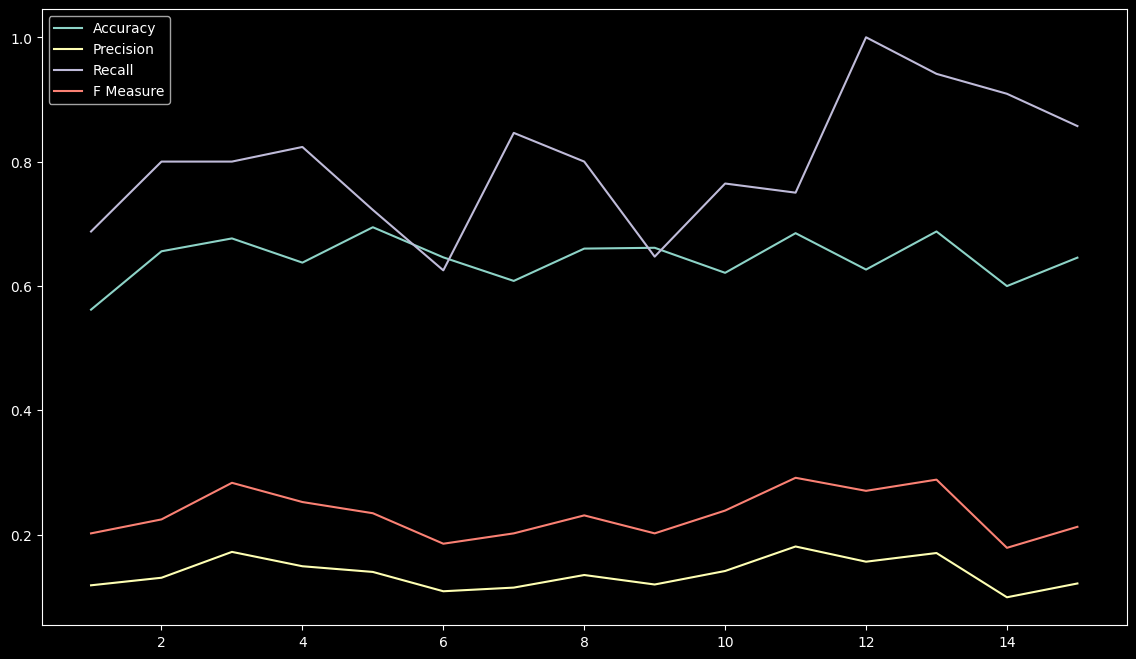

In [10]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(run_id, accuracy, label='Accuracy')
ax.plot(run_id, precision, label='Precision')
ax.plot(run_id, recall, label='Recall')
ax.plot(run_id, f_measure, label='F Measure')
ax.legend()

plt.show()


In [11]:
# persist model to disk
with open('models/chunking_model.pickle', 'wb') as file:
    pickle.dump(chunker, file, pickle.HIGHEST_PROTOCOL)
